In [1]:
%load_ext autoreload
%autoreload 2

# Results

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

### Functions

In [3]:
def custom_sat_cmap(basecolor, num, min_s=0.001):

    hsv = rgb_to_hsv(basecolor).tolist()
    new_s_lst = np.linspace(min_s, hsv[1], num)

    new_cmap = []
    for new_s in new_s_lst:
        hsv[1] = new_s
        new_cmap.append(hsv_to_rgb(hsv).tolist())

    return new_cmap

In [4]:
def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files


In [5]:
def get_training_log(log_path, log_item = 'Loss/train'):
    # log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

## Large-scale experiments

### Initialize

#### Variables

In [6]:
SCALE = 'LargeScale'
ARCHITECTURE = 'ResNet_50'  
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = [116, 30, 151]

CMAP = mpl.color_sequences['tab10']
CMAP_L = mpl.color_sequences['tab20b']
CMAP_C = mpl.color_sequences['Set3']
CMAP_H = mpl.colors.LinearSegmentedColormap.from_list("", ['gray','white']),

#### Evaluation data from SM

In [7]:
CATEGORY = '_RQ1'

sm_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'}
    ],

]

#### Evaluation data from EOS

In [8]:
CATEGORY = '_RQ1'

eos_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
    ]
]

#### Evaluation data from OvR

In [9]:
CATEGORY = '_RQ1'

ovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR'},
    ]
]

In [10]:
CATEGORY = '_RQ2'

ovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR (w/o neg)'},
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR (w/o neg)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR (w/o neg)'},
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'},
    ]
]

In [11]:
CATEGORY = '_RQ3'

ovr_data_info_3_C = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_C_b', 'OvR'], 'label': 'OvR-C'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_b', 'OvR'], 'label': 'OvR-C (batch)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_g', 'OvR'], 'label': 'OvR-C (global)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_C_b', 'OvR'], 'label': 'OvR-C'},
    ]
]

ovr_data_info_3_F = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_F_2', 'OvR'], 'label': 'OvR-F'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_1', 'OvR'], 'label': 'OvR-F (1)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_2', 'OvR'], 'label': 'OvR-F (2)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_3', 'OvR'], 'label': 'OvR-F (3)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_F_2', 'OvR'], 'label': 'OvR-F'},
    ]
]

ovr_data_info_3_M = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_M_6', 'OvR'], 'label': 'OvR-M'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_4', 'OvR'], 'label': 'OvR-M (0.4)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_6', 'OvR'], 'label': 'OvR-M (0.6)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_M_6', 'OvR'], 'label': 'OvR-M'},
    ]
]

#### Evaluation data from OSOvR

In [12]:
CATEGORY = '_Tuning'

osovr_data_info_T = [
    [
        None
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_sigma_6', 'OpenSetOvR'], 'label': 'OSOvR (6)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_sigma_8', 'OpenSetOvR'], 'label': 'OSOvR (8)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_sigma_12', 'OpenSetOvR'], 'label': 'OSOvR (12)'},
    ],
    [
        None
    ]
]

In [13]:
CATEGORY = '_RQ1'

osovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR'},
    ]
]

In [14]:
CATEGORY = '_RQ2'

osovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR (w/o neg)'},
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR (w/o neg)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR (w/o neg)'},
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg all)'},
    ]
]

In [16]:
CATEGORY = '_RQ3'

osovr_data_info_3_C = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_b', 'OpenSetOvR'], 'label': 'OSOvR-C (batch)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C (global)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
    ]
]

osovr_data_info_3_F = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_F_2', 'OpenSetOvR'], 'label': 'OSOvR-F'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_F_2', 'OpenSetOvR'], 'label': 'OSOvR-F'},
    ]
]

osovr_data_info_3_M = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_M_4', 'OpenSetOvR'], 'label': 'OSOvR-M'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_4', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_6', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_M_4', 'OpenSetOvR'], 'label': 'OSOvR-M'},
    ]
]

### 0. Tuning

In [16]:
PROTOCOL = 2

#### OSOvR - Sigma
- Best = 8

In [17]:
data_info = osovr_data_info_T[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_Tuning', 'ResNet_50_sigma_6', 'OpenSetOvR']
['LargeScale_2', '_Tuning', 'ResNet_50_sigma_8', 'OpenSetOvR']
['LargeScale_2', '_Tuning', 'ResNet_50_sigma_12', 'OpenSetOvR']


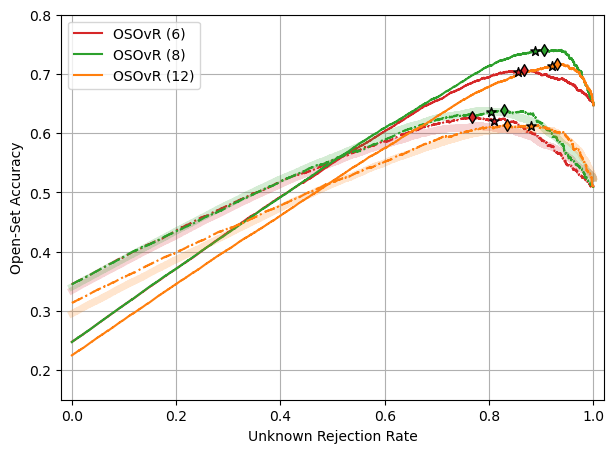

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7020	0.9657	0.5775	0.6123	0.6210	0.7038	0.6279	0.7073
0.7007	0.9655	0.6011	0.6383	0.6361	0.7384	0.6384	0.7409
0.6373	0.9520	0.5200	0.6084	0.6115	0.7134	0.6134	0.7167


In [18]:
evals.plot_OSAC(data_info, [CMAP[3],CMAP[2],CMAP[1]], figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

#### Loss weighting - C, F, M 
- Best C (OvR/OSOvR) : batch / batch
- Best F (OvR/OSOvR) : 2 / 2
- Best M (OvR/OSOvR) : 0.6 / 0.4

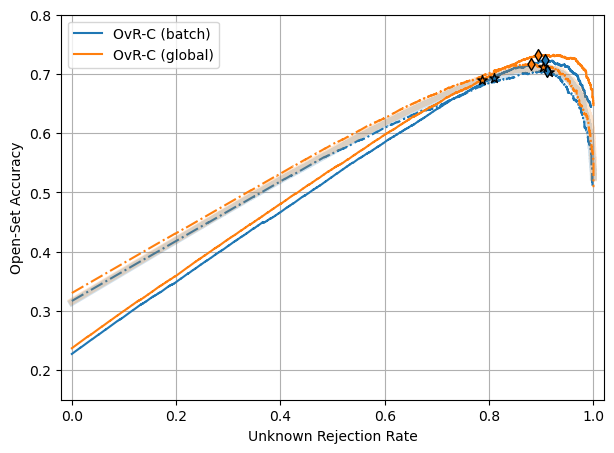

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6440	0.9653	0.5388	0.7109	0.7026	0.6939	0.7056	0.7231
0.6713	0.9664	0.5717	0.7105	0.7118	0.6901	0.7170	0.7325


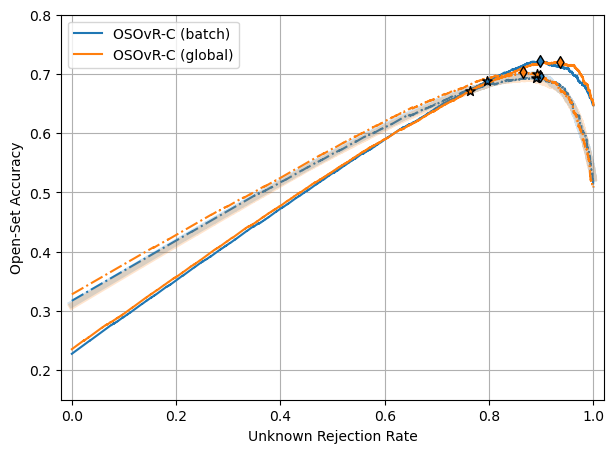

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6447	0.9609	0.5450	0.6983	0.6928	0.6880	0.6961	0.7214
0.6667	0.9620	0.5535	0.6929	0.7007	0.6715	0.7033	0.7207


In [19]:
PROTOCOL = 2

data_info = ovr_data_info_3_C[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_C[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

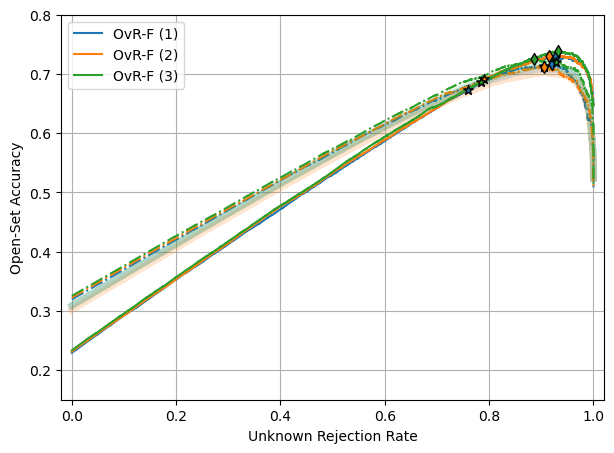

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6493	0.9490	0.5514	0.7093	0.7128	0.6722	0.7167	0.7299
0.6553	0.9549	0.5557	0.7034	0.7118	0.6920	0.7125	0.7304
0.6613	0.9597	0.5642	0.7153	0.7207	0.6864	0.7256	0.7395


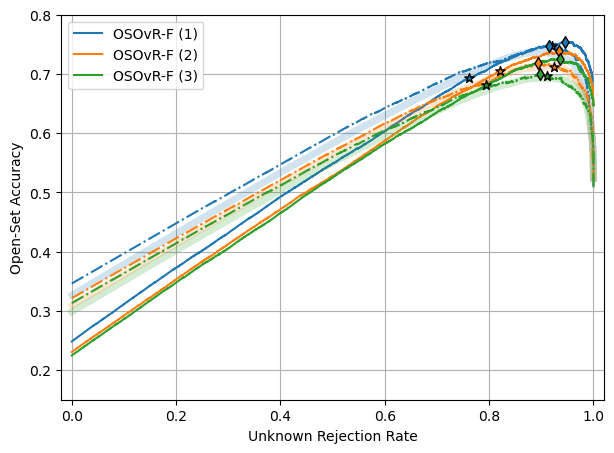

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7040	0.9605	0.6057	0.7387	0.7472	0.6932	0.7479	0.7546
0.6533	0.9552	0.5553	0.7137	0.7118	0.7045	0.7177	0.7381
0.6367	0.9522	0.5338	0.6941	0.6961	0.6809	0.6993	0.7259


In [20]:
data_info = ovr_data_info_3_F[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_F[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

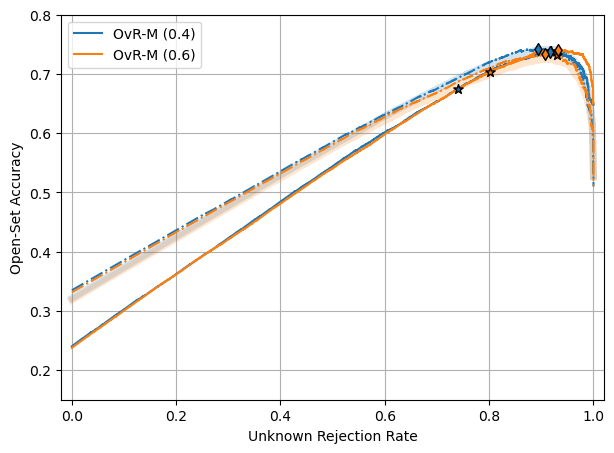

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6807	0.9538	0.5803	0.7414	0.7393	0.6751	0.7430	0.7372
0.6733	0.9522	0.5798	0.7254	0.7315	0.7040	0.7341	0.7407


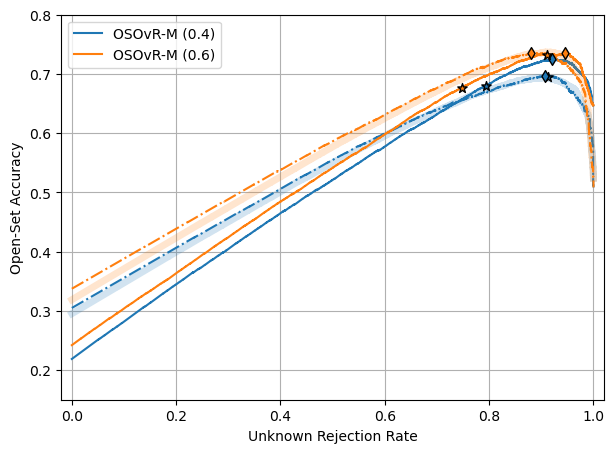

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6200	0.9521	0.5270	0.6940	0.6954	0.6795	0.6970	0.7247
0.6860	0.9544	0.5784	0.7370	0.7318	0.6767	0.7361	0.7351


In [21]:
data_info = ovr_data_info_3_M[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_M[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

### 1. Softmax-based vs. OvR-based loss

#### Protocol 1

In [37]:
PROTOCOL = 1

data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6612	0.9845	0.6232	0.6152	0.6225	0.7618	0.6236	0.7623
0.7022	0.9833	0.6544	0.6513	0.6581	0.7912	0.6613	0.7916
0.7043	0.9813	0.6562	0.6419	0.6521	0.7777	0.6537	0.7784


<Figure size 500x500 with 0 Axes>

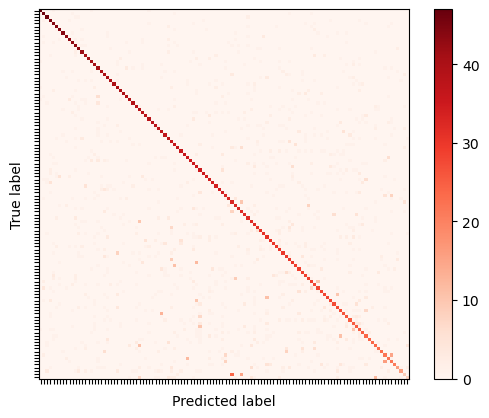

<Figure size 500x500 with 0 Axes>

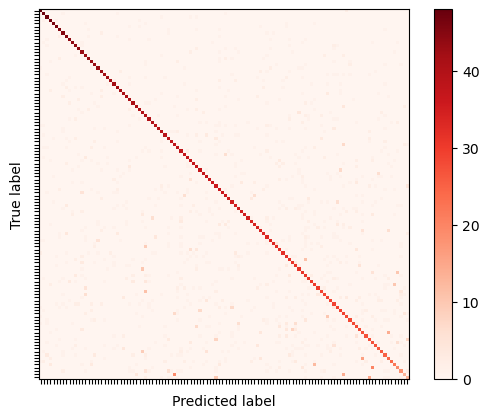

<Figure size 500x500 with 0 Axes>

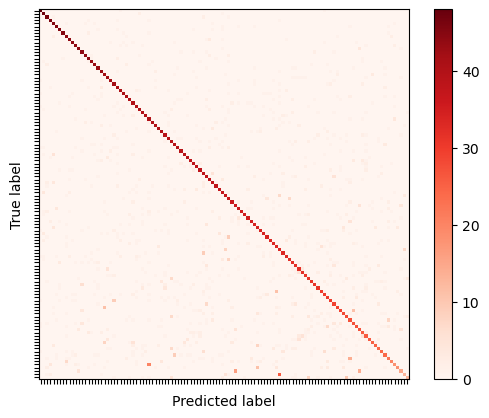

In [38]:
results = evals.print_metrics(data_info)
evals.plot_confusion_mat(data_info, colors=plt.cm.Reds,
                         set_diag_mask=False, set_cmap_range=None,
                         show_numbers=False, diag_sort=True)

##### Appendix

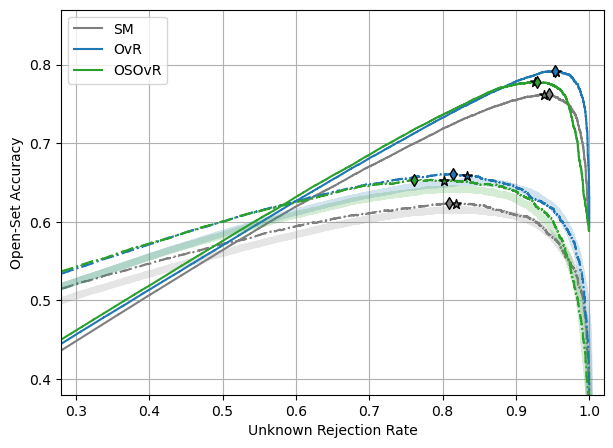

In [40]:
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)))

#### Protocol 2

In [41]:
PROTOCOL = 2

data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6533	0.9700	0.5487	0.6228	0.6144	0.7261	0.6223	0.7273
0.6867	0.9678	0.5690	0.6307	0.6331	0.7235	0.6364	0.7259
0.7007	0.9655	0.6011	0.6383	0.6361	0.7384	0.6384	0.7409


<Figure size 500x500 with 0 Axes>

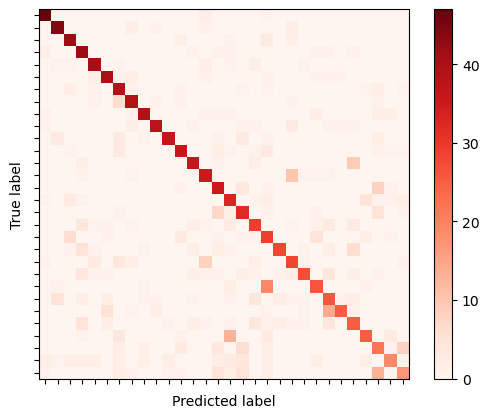

<Figure size 500x500 with 0 Axes>

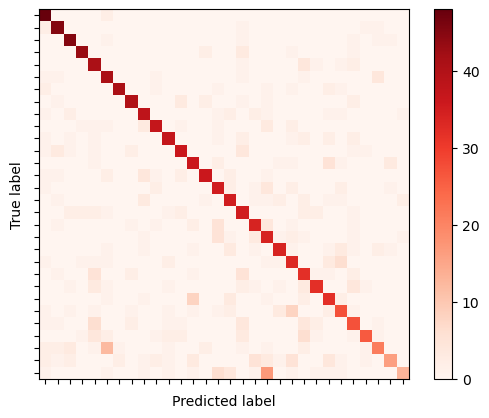

<Figure size 500x500 with 0 Axes>

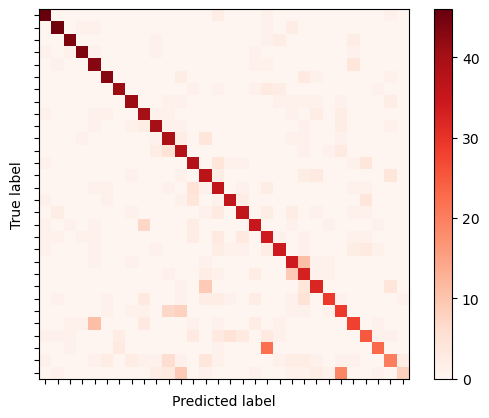

In [42]:
results = evals.print_metrics(data_info)
evals.plot_confusion_mat(data_info, colors=plt.cm.Reds,
                         set_diag_mask=False, set_cmap_range=None,
                         show_numbers=False, diag_sort=True)

##### Appendix

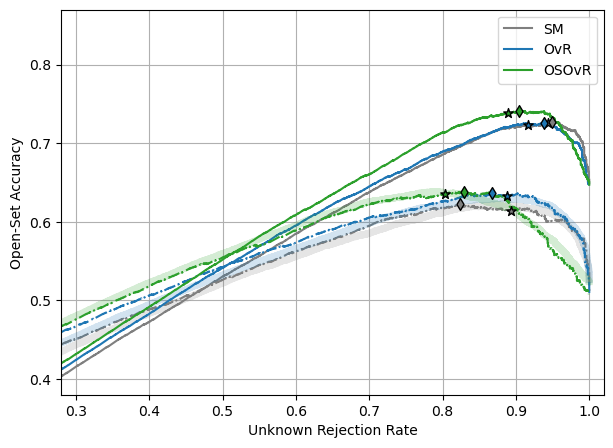

In [43]:
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)))

#### Protocol 3

In [44]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7754	0.9940	0.6822	0.6460	0.6515	0.7227	0.6531	0.7266
0.7645	0.9876	0.6778	0.6589	0.6614	0.7260	0.6623	0.7314
0.7893	0.9915	0.6816	0.6567	0.6585	0.7178	0.6592	0.7217


<Figure size 500x500 with 0 Axes>

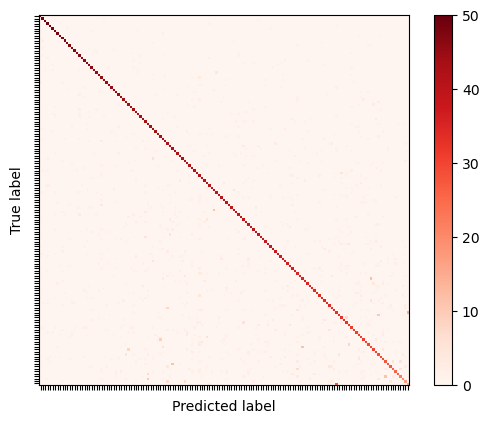

<Figure size 500x500 with 0 Axes>

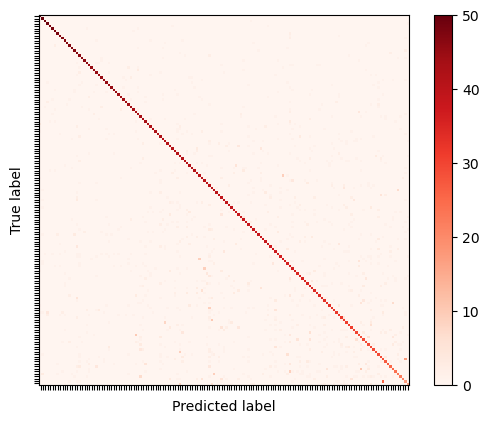

<Figure size 500x500 with 0 Axes>

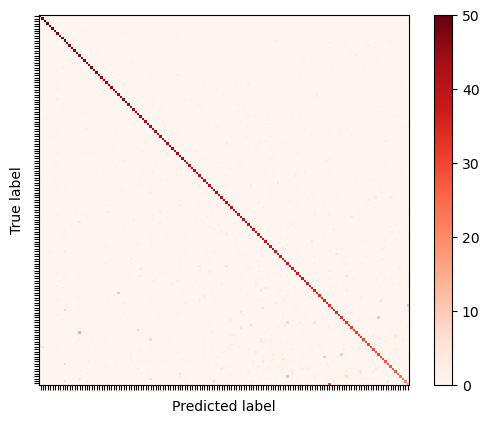

In [45]:
results = evals.print_metrics(data_info)
evals.plot_confusion_mat(data_info, colors=plt.cm.Reds,
                         set_diag_mask=False, set_cmap_range=None,
                         show_numbers=False, diag_sort=True)

##### Appendix

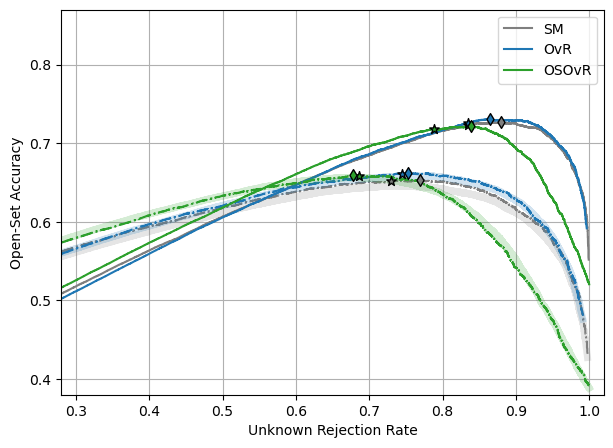

In [46]:
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)))

### 2. Examine the effect of the number of negatives in training.

#### Protocol 1

In [47]:
PROTOCOL = 1

data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7022	0.9833	0.6544	0.6513	0.6581	0.7912	0.6613	0.7916
0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947


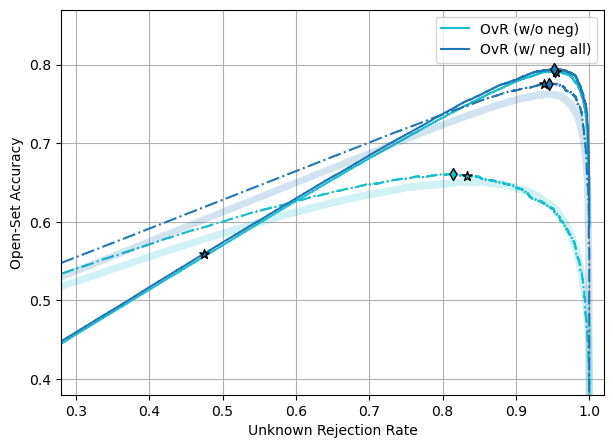

In [48]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[9],CMAP[0],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [49]:
PROTOCOL = 1

data_info = osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7043	0.9813	0.6562	0.6419	0.6521	0.7777	0.6537	0.7784
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036


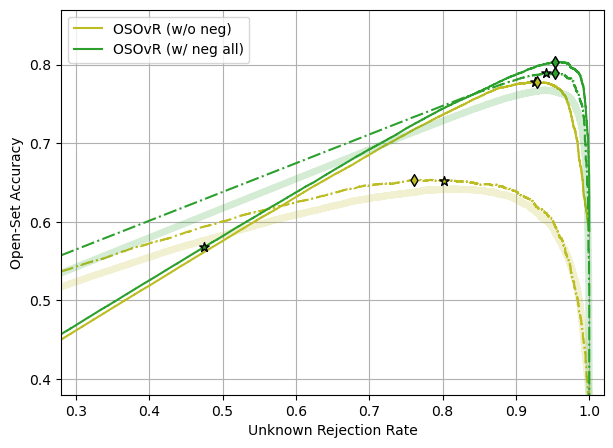

In [50]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[8],CMAP[2],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [62]:
PROTOCOL = 1

data_info = eos_data_info_1[PROTOCOL-1] + ovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_2[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6805	0.9789	0.6706	0.7669	0.7830	0.7671	0.7835	0.8184
0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036


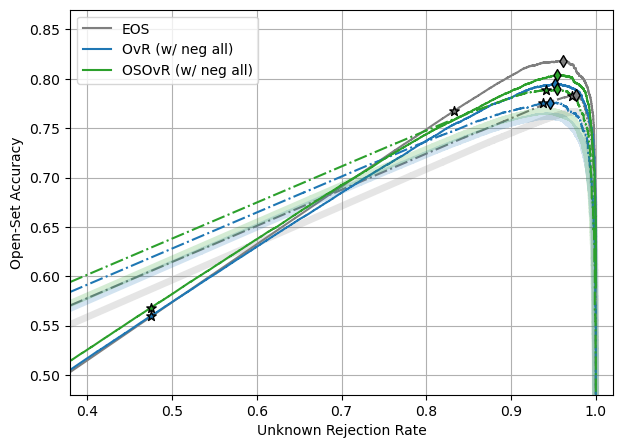

In [63]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], 
                figsize=(7,5), lim=((0.38, 1.02),(0.48,0.87)),
                show_val=True)

#### Protocol 2

In [56]:
PROTOCOL = 2

data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6867	0.9678	0.5690	0.6307	0.6331	0.7235	0.6364	0.7259
0.6600	0.9529	0.5706	0.7244	0.7269	0.7024	0.7325	0.7478


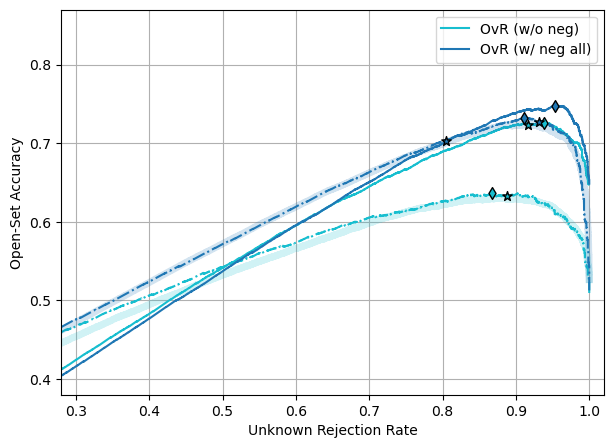

In [62]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[9],CMAP[0],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [63]:
PROTOCOL = 2

data_info = osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7007	0.9655	0.6011	0.6383	0.6361	0.7384	0.6384	0.7409
0.6540	0.9517	0.5492	0.7126	0.7095	0.6704	0.7111	0.7247


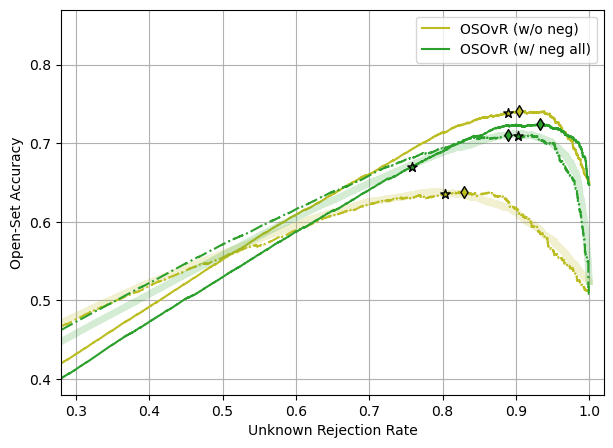

In [64]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[8],CMAP[2],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [64]:
PROTOCOL = 2

data_info = eos_data_info_1[PROTOCOL-1] + ovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_2[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6567	0.9413	0.5804	0.7484	0.7393	0.6781	0.7433	0.7527
0.6600	0.9529	0.5706	0.7244	0.7269	0.7024	0.7325	0.7478
0.6540	0.9517	0.5492	0.7126	0.7095	0.6704	0.7111	0.7247


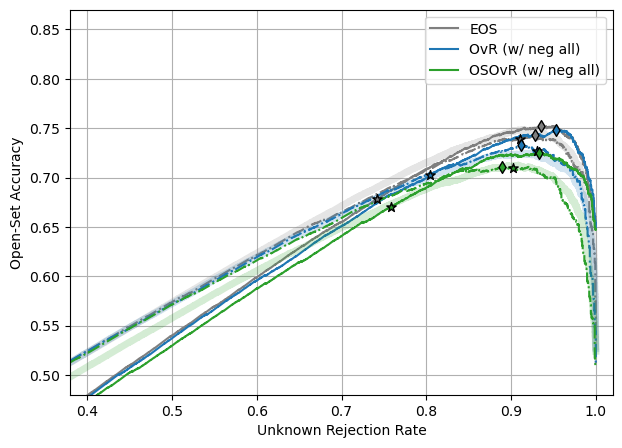

In [65]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], 
                figsize=(7,5), lim=((0.38, 1.02),(0.48,0.87)),
                show_val=True)

#### Protocol 3

In [54]:
PROTOCOL = 3

data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7645	0.9876	0.6778	0.6589	0.6614	0.7260	0.6623	0.7314
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343


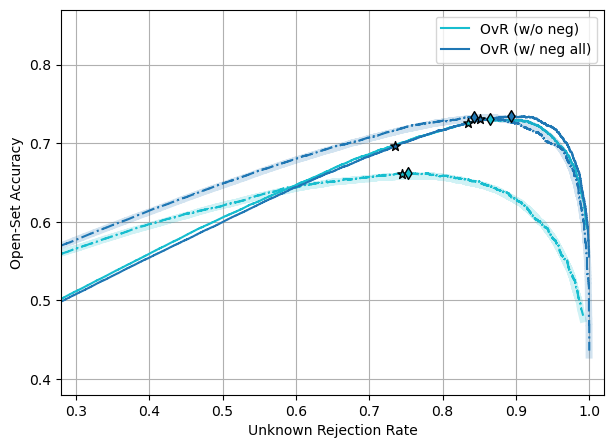

In [55]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[9],CMAP[0],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [56]:
PROTOCOL = 3

data_info = osovr_data_info_2[PROTOCOL-1]


for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.7893	0.9915	0.6816	0.6567	0.6585	0.7178	0.6592	0.7217
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437


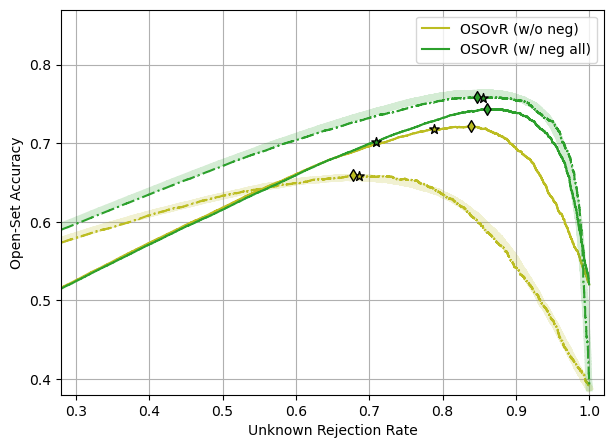

In [57]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[8],CMAP[2],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [66]:
PROTOCOL = 3

data_info = eos_data_info_1[PROTOCOL-1] + ovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_2[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7521	0.9783	0.6813	0.7524	0.7492	0.7053	0.7502	0.7420
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437


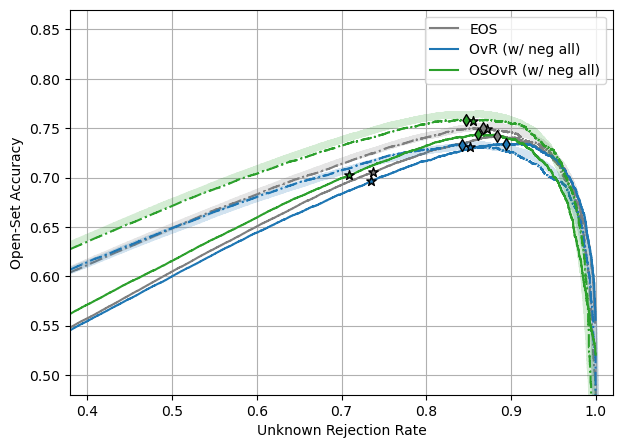

In [67]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], 
                figsize=(7,5), lim=((0.38, 1.02),(0.48,0.87)),
                show_val=True)

### 3. Comparing the type of loss weighting

#### Protocol 1

In [64]:
PROTOCOL = 1

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx])

{'info': ['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'}
{'info': ['LargeScale_1', '_RQ3', 'ResNet_50_C_b', 'OvR'], 'label': 'OvR-C'}
{'info': ['LargeScale_1', '_RQ3', 'ResNet_50_F_2', 'OvR'], 'label': 'OvR-F'}
{'info': ['LargeScale_1', '_RQ3', 'ResNet_50_M_6', 'OvR'], 'label': 'OvR-M'}


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947
0.6364	0.9834	0.5974	0.7071	0.7220	0.6670	0.7247	0.7634
0.6912	0.9781	0.6467	0.7479	0.7615	0.5448	0.7626	0.7862
0.7021	0.9841	0.6735	0.7577	0.7746	0.6641	0.7748	0.8061
average	std	model
0.3857	0.157	OvR (w/ neg all)
0.3589	0.170	OvR-C
0.3951	0.167	OvR-F
0.3386	0.157	OvR-M


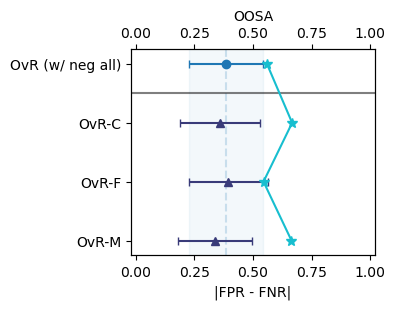

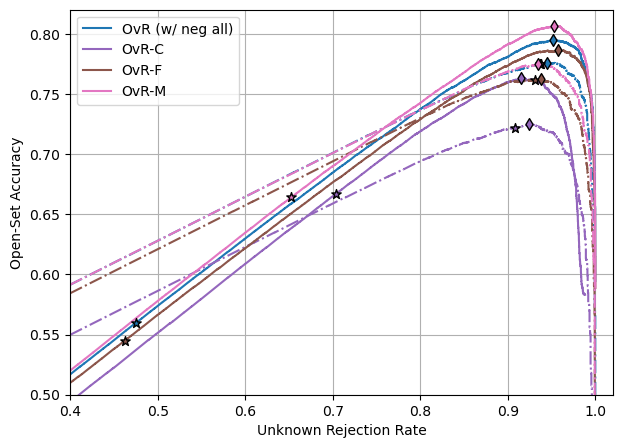

In [65]:
color = [CMAP[0]] + [CMAP_L[0]]*3
marker = ['o'] + ['^']*3

res_ovr = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_ovr['oosa']], 'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[0]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [17]:
PROTOCOL = 1

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036
0.6509	0.9824	0.5842	0.7268	0.7368	0.5496	0.7395	0.7259
0.6964	0.9826	0.6576	0.7548	0.7679	0.5878	0.7687	0.7896
0.7143	0.9873	0.6837	0.7640	0.7797	0.6826	0.7804	0.8074


average	std	model
0.3847	0.154	OSOvR (w/ neg all)
0.3487	0.155	OSOvR-C
0.3887	0.159	OSOvR-F
0.3186	0.152	OSOvR-M


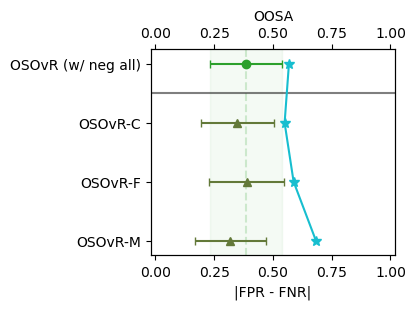

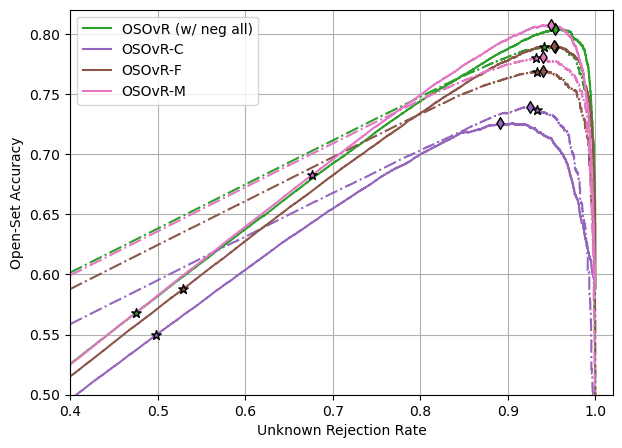

In [18]:
color = [CMAP[2]] + [CMAP_L[4]]*3
marker = ['o'] + ['^']*3

res_osovr = evals.print_metrics(data_info)
res_osovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4.2,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_osovr['oosa']], 
                                               'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[2]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [19]:
PROTOCOL = 1

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_b', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_6', 'OvR']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


In [20]:
res_osovr = evals.print_metrics(data_info)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6612	0.9845	0.6232	0.6152	0.6225	0.7618	0.6236	0.7623
0.6805	0.9789	0.6706	0.7669	0.7830	0.7671	0.7835	0.8184
0.7022	0.9833	0.6544	0.6513	0.6581	0.7912	0.6613	0.7916
0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947
0.6364	0.9834	0.5974	0.7071	0.7220	0.6670	0.7247	0.7634
0.6912	0.9781	0.6467	0.7479	0.7615	0.5448	0.7626	0.7862
0.7021	0.9841	0.6735	0.7577	0.7746	0.6641	0.7748	0.8061
0.7043	0.9813	0.6562	0.6419	0.6521	0.7777	0.6537	0.7784
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036
0.6509	0.9824	0.5842	0.7268	0.7368	0.5496	0.7395	0.7259
0.6964	0.9826	0.6576	0.7548	0.7679	0.5878	0.7687	0.7896
0.7143	0.9873	0.6837	0.7640	0.7797	0.6826	0.7804	0.8074


#### Protocol 2

In [68]:
PROTOCOL = 2

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1][:1] + ovr_data_info_3_F[PROTOCOL-1][1:2] + ovr_data_info_3_M[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_b', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_6', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6600	0.9529	0.5706	0.7244	0.7269	0.7024	0.7325	0.7478
0.6440	0.9653	0.5388	0.7109	0.7026	0.6939	0.7056	0.7231
0.6553	0.9549	0.5557	0.7034	0.7118	0.6920	0.7125	0.7304
0.6733	0.9522	0.5798	0.7254	0.7315	0.7040	0.7341	0.7407


average	std	model
0.4933	0.164	OvR (w/ neg all)
0.3658	0.156	OvR-C (batch)
0.5060	0.144	OvR-F (2)
0.4554	0.148	OvR-M (0.6)


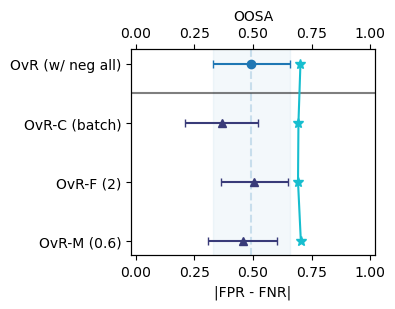

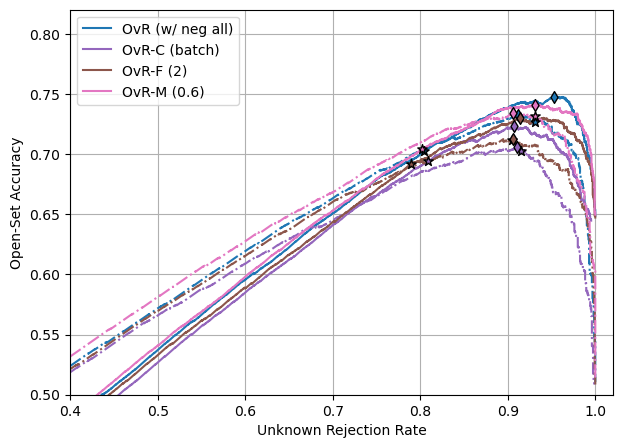

In [69]:
color = [CMAP[0]] + [CMAP_L[0]]*3
marker = ['o'] + ['^']*3

res_ovr = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_ovr['oosa']], 'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[0]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [70]:
PROTOCOL = 2

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1][:1] + osovr_data_info_3_F[PROTOCOL-1][1:2] + osovr_data_info_3_M[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_b', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6540	0.9517	0.5492	0.7126	0.7095	0.6704	0.7111	0.7247
0.6447	0.9609	0.5450	0.6983	0.6928	0.6880	0.6961	0.7214
0.6533	0.9552	0.5553	0.7137	0.7118	0.7045	0.7177	0.7381
0.6200	0.9521	0.5270	0.6940	0.6954	0.6795	0.6970	0.7247
average	std	model
0.5245	0.174	OSOvR (w/ neg all)
0.3633	0.153	OSOvR-C (batch)
0.5074	0.137	OSOvR-F (2)
0.5248	0.143	OSOvR-M (0.4)


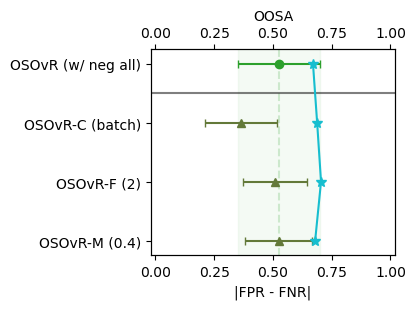

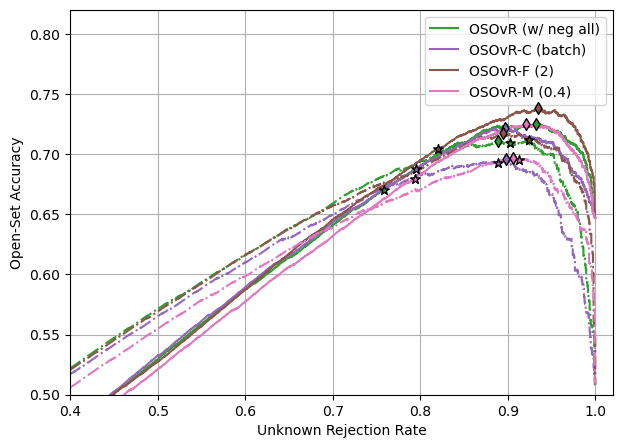

In [71]:
color = [CMAP[2]] + [CMAP_L[4]]*3
marker = ['o'] + ['^']*3

res_osovr = evals.print_metrics(data_info)
res_osovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4.2,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_osovr['oosa']], 'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[2]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [53]:
PROTOCOL = 2

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1]
data_info += ovr_data_info_3_C[PROTOCOL-1][:1] + ovr_data_info_3_F[PROTOCOL-1][1:2] + ovr_data_info_3_M[PROTOCOL-1][-1:]
data_info += osovr_data_info_2[PROTOCOL-1]
data_info += osovr_data_info_3_C[PROTOCOL-1][:1] + osovr_data_info_3_F[PROTOCOL-1][1:2] + osovr_data_info_3_M[PROTOCOL-1][:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_b', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_6', 'OvR']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_b', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


In [54]:
res_osovr = evals.print_metrics(data_info)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6533	0.9700	0.5487	0.6228	0.6144	0.7261	0.6223	0.7273
0.6567	0.9413	0.5804	0.7484	0.7393	0.6781	0.7433	0.7527
0.6867	0.9678	0.5690	0.6307	0.6331	0.7235	0.6364	0.7259
0.6600	0.9529	0.5706	0.7244	0.7269	0.7024	0.7325	0.7478
0.6440	0.9653	0.5388	0.7109	0.7026	0.6939	0.7056	0.7231
0.6553	0.9549	0.5557	0.7034	0.7118	0.6920	0.7125	0.7304
0.6733	0.9522	0.5798	0.7254	0.7315	0.7040	0.7341	0.7407
0.7007	0.9655	0.6011	0.6383	0.6361	0.7384	0.6384	0.7409
0.6540	0.9517	0.5492	0.7126	0.7095	0.6704	0.7111	0.7247
0.6447	0.9609	0.5450	0.6983	0.6928	0.6880	0.6961	0.7214
0.6533	0.9552	0.5553	0.7137	0.7118	0.7045	0.7177	0.7381


0.6200	0.9521	0.5270	0.6940	0.6954	0.6795	0.6970	0.7247


##### appendix

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
average	std	model


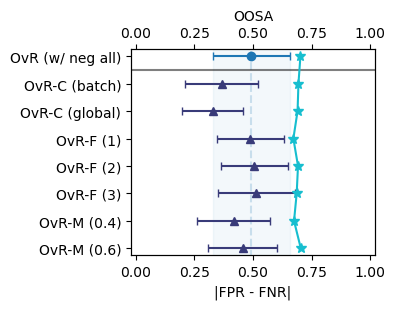

In [55]:
PROTOCOL = 2

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]

color = [CMAP[0]] + [CMAP_L[0]]*8
marker = ['o'] + ['^']*8

res_ovr = evals.print_metrics(data_info, is_verbose=False)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_ovr['oosa']], 'color': CMAP[9], 'lim':(-0.02,1.02)},
                                     is_verbose=False)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
average	std	model


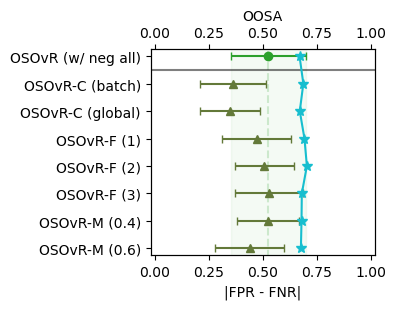

In [56]:
PROTOCOL = 2

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

color = [CMAP[2]] + [CMAP_L[4]]*8
marker = ['o'] + ['^']*8

res_osovr = evals.print_metrics(data_info, is_verbose=False)
res_osovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_osovr['oosa']], 'color': CMAP[9], 'lim':(-0.02,1.02)},
                                     is_verbose=False)

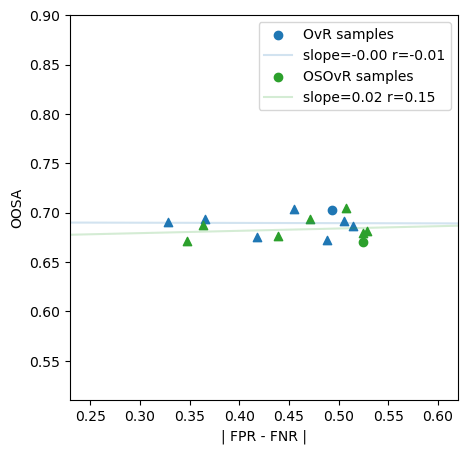

In [57]:
bump = 0.02
span = 0.35 + bump * 2
ystart = 0.53 - bump
xstart = 0.25 - bump
marker = ['o'] + ['^']*7

res_ovr_oosa = [res['oosa_unkn'] for res in res_ovr['oosa']]
res_osovr_oosa = [res['oosa_unkn'] for res in res_osovr['oosa']]

plt.figure(figsize=(5,5))
for i in range(len(res_ovr_oosa)):
    if i == 0:
        plt.scatter(res_ovr_fpr_fnr[i], res_ovr_oosa[i], label='OvR samples', marker=marker[i], c=CMAP[0])
    else:
        plt.scatter(res_ovr_fpr_fnr[i], res_ovr_oosa[i], marker=marker[i], c=CMAP[0])

res = stats.linregress(res_ovr_fpr_fnr, res_ovr_oosa)
line = f'slope={res.slope:.2f} r={res.rvalue:.2f}'
x = np.linspace(xstart, xstart+span, 10)
plt.plot(x, res.intercept + res.slope * x, label=line, c=CMAP[0], alpha=0.2)

for i in range(len(res_osovr_oosa)):
    if i == 0:
        plt.scatter(res_osovr_fpr_fnr[i], res_osovr_oosa[i], label='OSOvR samples', marker=marker[i], c=CMAP[2])
    else:
        plt.scatter(res_osovr_fpr_fnr[i], res_osovr_oosa[i], marker=marker[i], c=CMAP[2])

res = stats.linregress(res_osovr_fpr_fnr, res_osovr_oosa)
line = f'slope={res.slope:.2f} r={res.rvalue:.2f}'
x = np.linspace(xstart, xstart+span, 10)
plt.plot(x, res.intercept + res.slope * x, label=line, c=CMAP[2], alpha=0.2)

plt.legend()

plt.xlim(xstart, xstart+span)
plt.ylim(ystart, ystart+span)
plt.xlabel('| FPR - FNR |')
plt.ylabel('OOSA')
plt.show()

#### Protocol 3

In [72]:
PROTOCOL = 3

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx])

{'info': ['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'}
{'info': ['LargeScale_3', '_RQ3', 'ResNet_50_C_b', 'OvR'], 'label': 'OvR-C'}
{'info': ['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OvR'], 'label': 'OvR-F'}
{'info': ['LargeScale_3', '_RQ3', 'ResNet_50_M_6', 'OvR'], 'label': 'OvR-M'}


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7336	0.9888	0.6352	0.6765	0.6791	0.6732	0.6793	0.6935
0.7430	0.9809	0.6527	0.7088	0.7123	0.6938	0.7137	0.7224
0.7572	0.9838	0.6663	0.7239	0.7273	0.6963	0.7281	0.7200
average	std	model
0.3688	0.180	OvR (w/ neg all)
0.2645	0.159	OvR-C
0.3922	0.172	OvR-F
0.3204	0.165	OvR-M


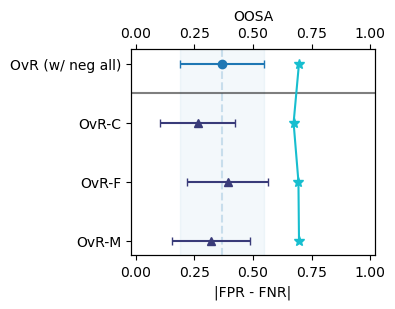

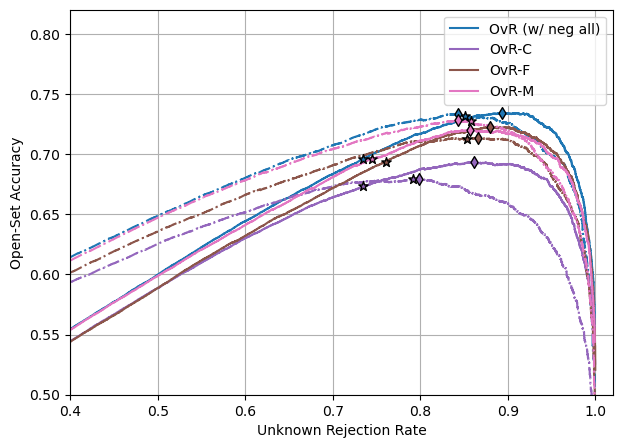

In [73]:
color = [CMAP[0]] + [CMAP_L[0]]*3
marker = ['o'] + ['^']*3

res_ovr = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_ovr['oosa']], 'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[0]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [21]:
PROTOCOL = 3

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437
0.7836	0.9953	0.6520	0.7195	0.7134	0.6589	0.7144	0.6909
0.7974	0.9913	0.7132	0.7679	0.7669	0.7054	0.7679	0.7515
0.7865	0.9889	0.5762	0.6714	0.6691	0.5650	0.6706	0.6283
average	std	model
0.3315	0.168	OSOvR (w/ neg all)
0.2186	0.123	OSOvR-C
0.3251	0.173	OSOvR-F
0.3491	0.137	OSOvR-M


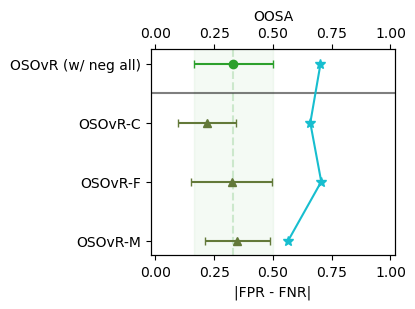

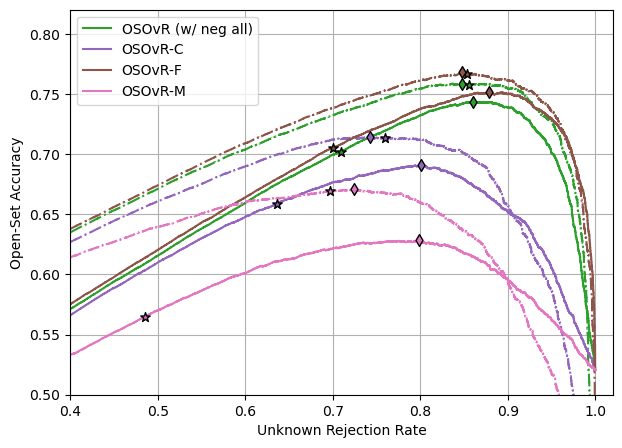

In [22]:
color = [CMAP[2]] + [CMAP_L[4]]*3
marker = ['o'] + ['^']*3

res_osovr = evals.print_metrics(data_info)
res_osovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4.2,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_osovr['oosa']], 
                                               'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[2]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [62]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_b', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_6', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_b', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


In [63]:
res_osovr = evals.print_metrics(data_info)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.7754	0.9940	0.6822	0.6460	0.6515	0.7227	0.6531	0.7266
0.7521	0.9783	0.6813	0.7524	0.7492	0.7053	0.7502	0.7420
0.7645	0.9876	0.6778	0.6589	0.6614	0.7260	0.6623	0.7314
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7336	0.9888	0.6352	0.6765	0.6791	0.6732	0.6793	0.6935
0.7430	0.9809	0.6527	0.7088	0.7123	0.6938	0.7137	0.7224
0.7572	0.9838	0.6663	0.7239	0.7273	0.6963	0.7281	0.7200
0.7893	0.9915	0.6816	0.6567	0.6585	0.7178	0.6592	0.7217
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437
0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000
0.7974	0.9913	0.7132	0.7679	0.7669	0.7054	0.7679	0.7515
0.7865	0.9889	0.5762	0.6714	0.6691	0.5650	0.6706	0.6283


### Summary

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6805	0.9789	0.6706	0.7669	0.7830	0.7671	0.7835	0.8184
0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947
0.6364	0.9834	0.5974	0.7071	0.7220	0.6670	0.7247	0.7634
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036
0.7143	0.9873	0.6837	0.7640	0.7797	0.6826	0.7804	0.8074


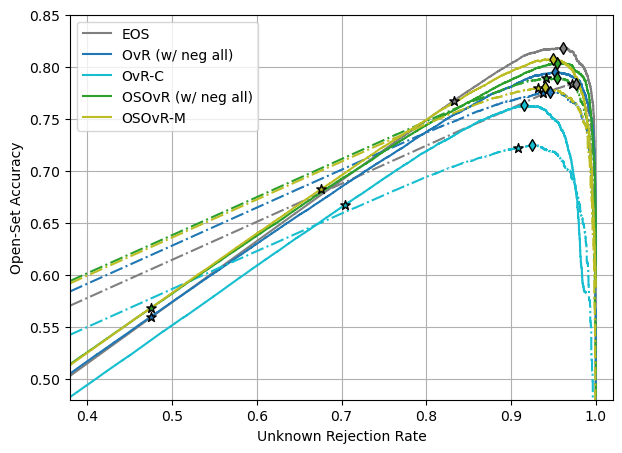

In [32]:
PROTOCOL = 1

data_info = eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1][-1:] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_3_M[PROTOCOL-1]
data_info = data_info[:5]
color = [CMAP[7],CMAP[0],CMAP[9],CMAP[2],CMAP[8],]

# for idx in range(len(data_info)):
#     print(data_info[idx]['info'])

res = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, color, 
                figsize=(7,5), lim=((.38,1.02),(.48,.85)),
                show_val=False)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6567	0.9413	0.5804	0.7484	0.7393	0.6781	0.7433	0.7527
0.6600	0.9529	0.5706	0.7244	0.7269	0.7024	0.7325	0.7478
0.6733	0.9522	0.5798	0.7254	0.7315	0.7040	0.7341	0.7407
0.6540	0.9517	0.5492	0.7126	0.7095	0.6704	0.7111	0.7247
0.6533	0.9552	0.5553	0.7137	0.7118	0.7045	0.7177	0.7381


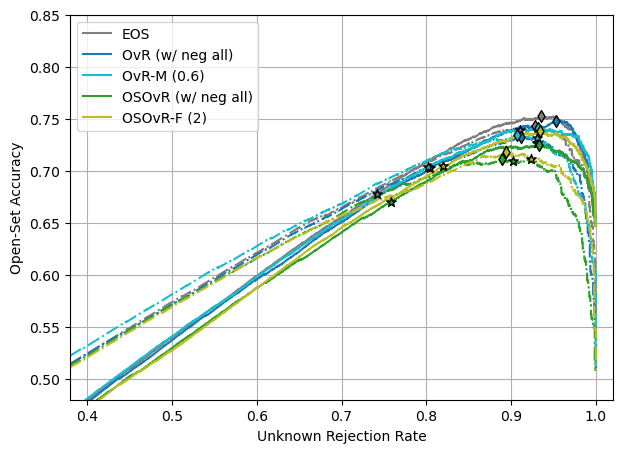

In [35]:
PROTOCOL = 2

data_info = eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1][-1:] + ovr_data_info_3_M[PROTOCOL-1][-1:]
data_info += osovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_3_F[PROTOCOL-1][1:2]
data_info = data_info[:5]
color = [CMAP[7],CMAP[0],CMAP[9],CMAP[2],CMAP[8],]

# for idx in range(len(data_info)):
#     print(data_info[idx]['info'])

res = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, color, 
                figsize=(7,5), lim=((.38,1.02),(.48,.85)),
                show_val=False)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7521	0.9783	0.6813	0.7524	0.7492	0.7053	0.7502	0.7420
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7572	0.9838	0.6663	0.7239	0.7273	0.6963	0.7281	0.7200
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437
0.7974	0.9913	0.7132	0.7679	0.7669	0.7054	0.7679	0.7515


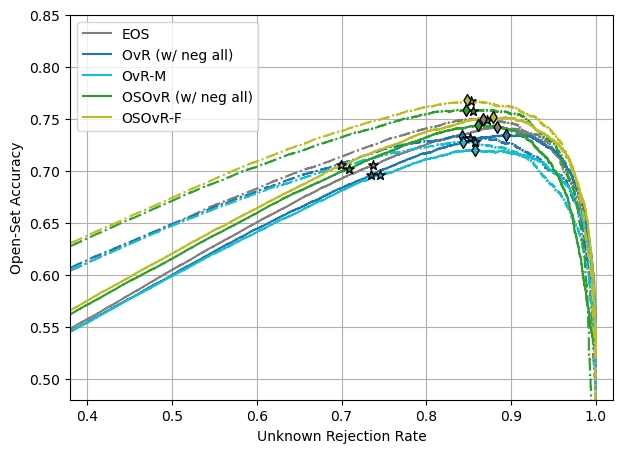

In [36]:
PROTOCOL = 3

data_info = eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1][-1:] + ovr_data_info_3_M[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_3_F[PROTOCOL-1]
data_info = data_info[:5]
color = [CMAP[7],CMAP[0],CMAP[9],CMAP[2],CMAP[8],]

# for idx in range(len(data_info)):
#     print(data_info[idx]['info'])

res = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, color, 
                figsize=(7,5), lim=((.38,1.02),(.48,.85)),
                show_val=False)

### 4. Training progress

In [16]:
log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


In [38]:
ITEM_IDX = 2
log_item_list[ITEM_IDX][0]

'Acc/train'

#### Protocol 1

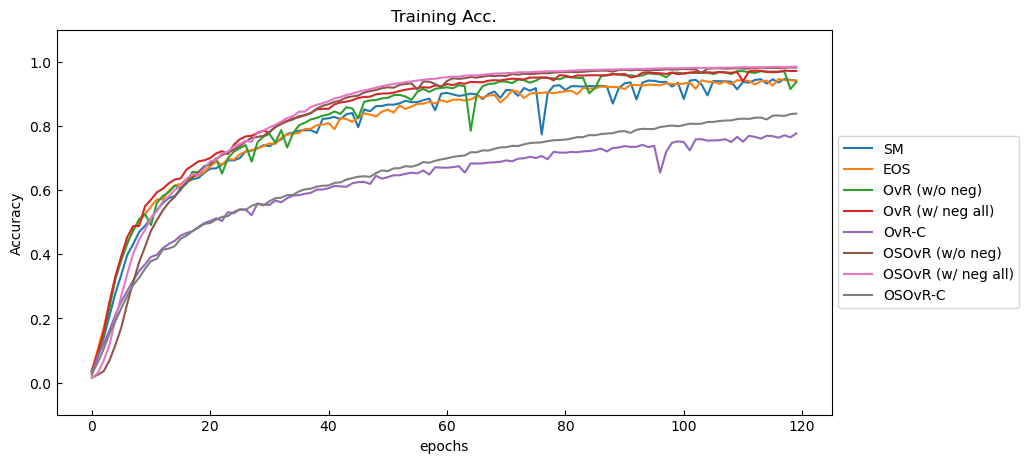

In [39]:
PROTOCOL = 1

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 2

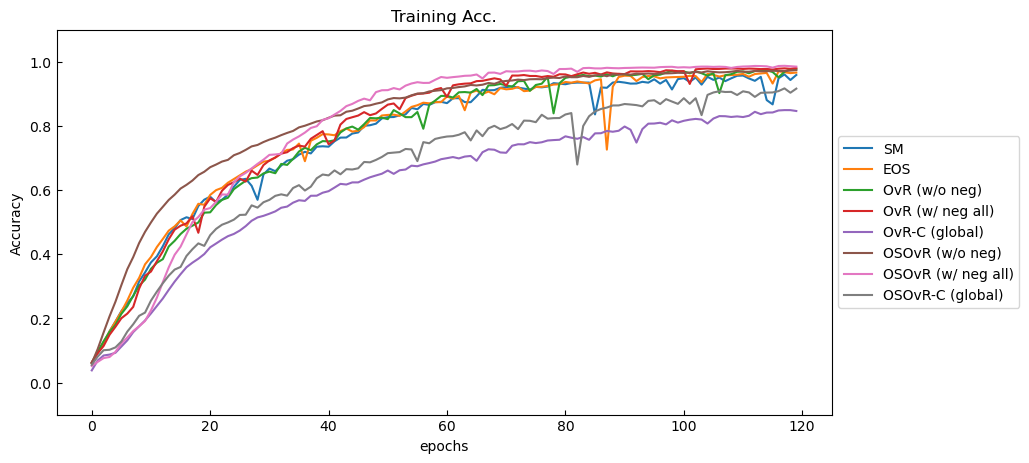

In [40]:
PROTOCOL = 2

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1][-1:]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1][-1:]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 3

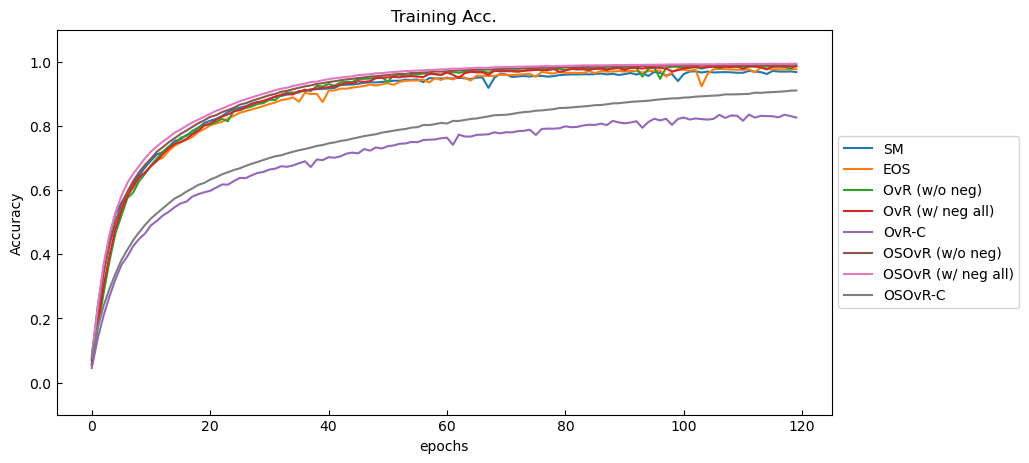

In [41]:
PROTOCOL = 3

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')
